# Gesture Recognition
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

Thumbs up:  Increase the volume,
Thumbs down: Decrease the volume,
Left swipe: 'Jump' backwards 10 seconds,
Right swipe: 'Jump' forward 10 seconds,
Stop: Pause the movie,

In [ ]:
!pip install imageio

In [ ]:
!pip install scipy

In [ ]:
!pip install Pillow

In [ ]:
!pip install tensorflow

In [ ]:
!pip install imgaug
!pip install ipyplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import os
import zipfile
import datetime
import matplotlib.pyplot as plt
import imgaug as ia
import imgaug.augmenters as iaa

from random import randint
from skimage.transform import resize
from imageio import imread

import warnings

warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn

rn.seed(30)
from keras import backend as K
import tensorflow as tf

tf.random.set_seed(30)

In [ ]:
from google.colab import drive

drive.mount("/content/drive/")

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Project_data.zip", "r")
zip_ref.extractall("/content/")
zip_ref.close()

Mounted at /content/drive/


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open("/content/Project_data/train.csv").readlines())
val_doc = np.random.permutation(open("/content/Project_data/val.csv").readlines())
batch_size = 32

In [ ]:
number_batches = train_doc.shape[0] // batch_size
print(number_batches)
remainder_number_files = train_doc.shape[0] % batch_size
print(remainder_number_files)

20
23


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
channels = 3
num_classes = 5
total_frames = 30
frames_to_sample = 30
image_height = 50
image_width = 50


def generator(source_path, folder_list, batch_size, augmented=False, plot=False):
    print("Source path = ", source_path, "; batch size =", batch_size)
    img_idx = np.arange(
        0, total_frames, 3
    )  # create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size  # calculate the number of batches
        for batch in range(num_batches):  # we iterate over the number of batches
            batch_data = np.zeros(
                (batch_size, len(img_idx), image_width, image_height, channels)
            )  # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros(
                (batch_size, num_classes)
            )  # batch_labels is the one hot representation of the output
            for folder in range(batch_size):  # iterate over the batch_size
                imgs = os.listdir(
                    source_path + "/" + t[folder + (batch * batch_size)].split(";")[0]
                )  # read all the images in the folder
                for idx, item in enumerate(
                    img_idx
                ):  #  Iterate iver the frames/images of a folder to read them in
                    image = imread(
                        source_path
                        + "/"
                        + t[folder + (batch * batch_size)].strip().split(";")[0]
                        + "/"
                        + imgs[item]
                    ).astype(np.float32)

                    # crop the images and resize them. Note that the images are of 2 different shape
                    # and the conv3D will throw error if the inputs in a batch have different shapes

                    if augmented:
                        aug_type = randint(0, 5)
                        if aug_type == 0:
                            aug_func = iaa.Crop(percent=(0, 0.1))
                            aug_image = aug_func.augment_image(image)
                        elif aug_type == 1:
                            aug_func = iaa.Sharpen(
                                alpha=(0, 1.0), lightness=(0.75, 1.5)
                            )
                            aug_image = aug_func.augment_image(image)
                        elif aug_type == 2:
                            aug_func = iaa.LinearContrast((0.75, 1.5))
                            aug_image = aug_func.augment_image(image)
                        elif aug_type == 3:
                            aug_func = iaa.AdditiveGaussianNoise(
                                loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5
                            )
                            aug_image = aug_func.augment_image(image)
                        elif aug_type == 4:
                            aug_func = iaa.Affine(
                                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                                rotate=(-25, 25),
                                shear=(-8, 8),
                            )
                            aug_image = aug_func.augment_image(image)
                        else:
                            aug_image = image

                        image = resize(aug_image, (image_width, image_height))

                    else:
                        image = resize(image, (image_width, image_height))

                    if plot:
                        length = len(img_idx)
                        plt.subplot(2, length, idx + length + 1)
                        plt.imshow(image.astype("uint8"))

                    batch_data[folder, idx, :, :, 0] = image[:, :, 0] / 255
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1] / 255
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2] / 255

                batch_labels[
                    folder, int(t[folder + (batch * batch_size)].strip().split(";")[2])
                ] = 1
            yield batch_data, batch_labels
        rem_image = len(folder_list) % batch_size
        batch += 1
        if rem_image != 0:
            batch_data = np.zeros(
                (rem_image, len(img_idx), image_width, image_height, channels)
            )  # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros(
                (rem_image, num_classes)
            )  # batch_labels is the one hot representation of the output
            for folder in range(rem_image):  # iterate over the batch_size
                imgs = os.listdir(
                    source_path + "/" + t[folder + (batch * batch_size)].split(";")[0]
                )  # read all the images in the folder
                for idx, item in enumerate(
                    img_idx
                ):  #  Iterate iver the frames/images of a folder to read them in
                    image = imread(
                        source_path
                        + "/"
                        + t[folder + (batch * batch_size)].strip().split(";")[0]
                        + "/"
                        + imgs[item]
                    ).astype(np.float32)

                    # crop the images and resize them. Note that the images are of 2 different shape
                    # and the conv3D will throw error if the inputs in a batch have different shapes

                    if augmented:
                        aug_type = randint(0, 5)
                        if aug_type == 0:
                            aug_func = iaa.Crop(percent=(0, 0.1))
                            aug_image = aug_func.augment_image(image)
                        elif aug_type == 1:
                            aug_func = iaa.Sharpen(
                                alpha=(0, 1.0), lightness=(0.75, 1.5)
                            )
                            aug_image = aug_func.augment_image(image)
                        elif aug_type == 2:
                            aug_func = iaa.LinearContrast((0.75, 1.5))
                            aug_image = aug_func.augment_image(image)
                        elif aug_type == 3:
                            aug_func = iaa.AdditiveGaussianNoise(
                                loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5
                            )
                            aug_image = aug_func.augment_image(image)
                        elif aug_type == 4:
                            aug_func = iaa.Affine(
                                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                                rotate=(-25, 25),
                                shear=(-8, 8),
                            )
                            aug_image = aug_func.augment_image(image)
                        else:
                            aug_image = image
                        image = resize(aug_image, (image_width, image_height))

                    else:
                        image = resize(image, (image_width, image_height))

                    if plot:
                        length = len(img_idx)
                        plt.subplot(2, length, idx + length + 1)
                        plt.imshow(image.astype("uint8"))

                    batch_data[folder, idx, :, :, 0] = image[:, :, 0] / 255
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1] / 255
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2] / 255

                batch_labels[
                    folder, int(t[folder + (batch * batch_size)].strip().split(";")[2])
                ] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = "/content/Project_data/train"
val_path = "/content/Project_data/val"
num_train_sequences = len(train_doc)
print("# training sequences =", num_train_sequences)
num_val_sequences = len(val_doc)
print("# validation sequences =", num_val_sequences)
num_epochs = 30
print("# epochs =", num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


Source path =  /content/Project_data/train ; batch size = 32


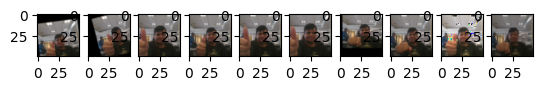

In [ ]:
test_gen_augment = generator(
    train_path, train_doc, batch_size, augmented=True, plot=True
)
d = next(test_gen_augment)[0]

Source path =  /content/Project_data/train ; batch size = 32


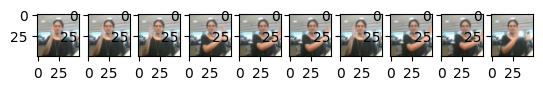

In [ ]:
test_gen = generator(train_path, train_doc, batch_size, augmented=False, plot=True)
d = next(test_gen)[0]

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import (
    Dense,
    GRU,
    Flatten,
    TimeDistributed,
    Flatten,
    BatchNormalization,
    Activation,
)
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Dropout, LSTM
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = (
    "model_init" + "_" + str(curr_dt_time).replace(" ", "").replace(":", "_") + "/"
)

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = (
    model_name
    + "model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5"
)

checkpoint = ModelCheckpoint(
    filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    period=1,
)

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1

In [ ]:
def plot_history(history, epochs):
    acc = history.history["categorical_accuracy"]
    val_acc = history.history["val_categorical_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    plt.show()

**Model 1**- Conv3D model without batch normalization,Drop out and regularization.

In [ ]:
model = Sequential()
model.add(
    Conv3D(
        16,
        (3, 3, 3),
        padding="same",
        input_shape=(10, image_height, image_width, channels),
    )
)
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(32, (2, 2, 2), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, (2, 2, 2), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(128, (2, 2, 2), padding="same"))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))

In [ ]:
model.compile(
    loss="categorical_crossentropy", optimizer="sgd", metrics=["categorical_accuracy"]
)

# summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 50, 50, 16)    1312      
                                                                 
 activation (Activation)     (None, 10, 50, 50, 16)    0         
                                                                 
 max_pooling3d (MaxPooling3  (None, 5, 25, 25, 16)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 25, 25, 32)     4128      
                                                                 
 activation_1 (Activation)   (None, 5, 25, 25, 32)     0         
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 2, 12, 12, 32)     0         
 g3D)                                                   

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=None,
    workers=1,
    initial_epoch=0,
)

Source path =  /content/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.6080 - categorical_accuracy: 0.2413Source path =  /content/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2023-12-0517_58_42.919558/model-00001-1.60802-0.24133-1.60715-0.20000.h5
21/21 [==============================] - 70s 3s/step - loss: 1.6080 - categorical_accuracy: 0.2413 - val_loss: 1.6071 - val_categorical_accuracy: 0.2000 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.6062 - categorical_accuracy: 0.2443
Epoch 2: saving model to model_init_2023-12-0517_58_42.919558/model-00002-1.60618-0.24434-1.60670-0.19000.h5
21/21 [==============================] - 64s 3s/step - loss: 1.6062 - categorical_accuracy: 0.2443 - val_loss: 1.6067 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.6046 - categorical_accuracy: 0.2368
Epoch 3: sav

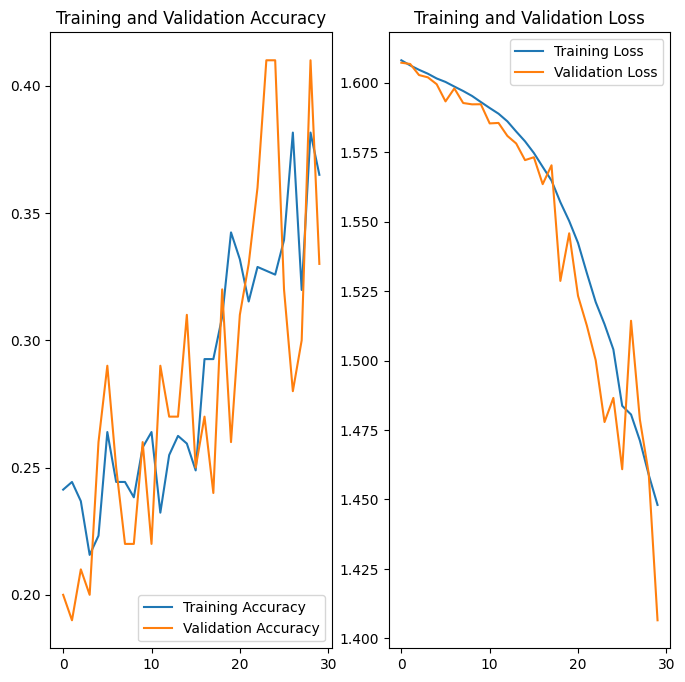

In [ ]:
plot_history(history, num_epochs)

**Model 2**- With batch normailzation, Dropout and regularization

In [ ]:
model = Sequential()
model.add(
    Conv3D(
        16,
        (3, 3, 3),
        padding="same",
        input_shape=(10, image_height, image_width, channels),
    )
)
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv3D(32, (2, 2, 2), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv3D(64, (2, 2, 2), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv3D(128, (2, 2, 2), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, kernel_regularizer=l2(0.01), activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))

In [ ]:
model.compile(
    loss="categorical_crossentropy", optimizer="sgd", metrics=["categorical_accuracy"]
)

# summary of model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 10, 50, 50, 16)    1312      
                                                                 
 activation_4 (Activation)   (None, 10, 50, 50, 16)    0         
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 5, 25, 25, 16)     0         
 g3D)                                                            
                                                                 
 batch_normalization (Batch  (None, 5, 25, 25, 16)     64        
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 5, 25, 25, 16)     0         
                                                                 
 conv3d_5 (Conv3D)           (None, 5, 25, 25, 32)    

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=None,
    workers=1,
    initial_epoch=0,
)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 6.3462 - categorical_accuracy: 0.3469
Epoch 1: saving model to model_init_2023-12-0517_58_42.919558/model-00001-6.34621-0.34691-6.41534-0.26000.h5
21/21 [==============================] - 72s 3s/step - loss: 6.3462 - categorical_accuracy: 0.3469 - val_loss: 6.4153 - val_categorical_accuracy: 0.2600 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 6.0142 - categorical_accuracy: 0.4661
Epoch 2: saving model to model_init_2023-12-0517_58_42.919558/model-00002-6.01418-0.46606-6.40751-0.16000.h5
21/21 [==============================] - 63s 3s/step - loss: 6.0142 - categorical_accuracy: 0.4661 - val_loss: 6.4075 - val_categorical_accuracy: 0.1600 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 5.8187 - categorical_accuracy: 0.5566
Epoch 3: saving model to model_init_2023-12-0517_58_42.919558/model-00003-5.81867-0.55656-6.43545-0.16000.h5
21/21 [================

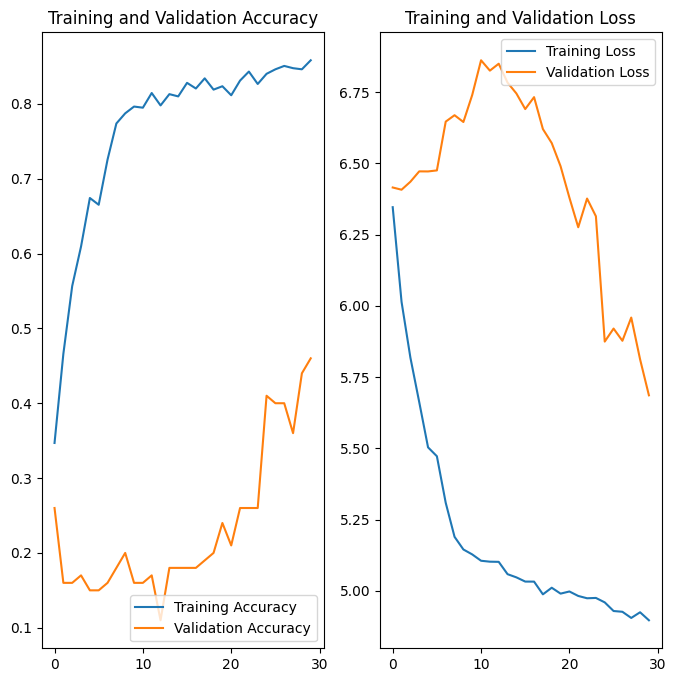

In [ ]:
plot_history(history, num_epochs)

**Model 3**: Augmented Data without batch normailzation, Dropout and regularization

In [ ]:
train_aug_generator = generator(train_path, train_doc, batch_size, augmented=True)
val_aug_generator = generator(val_path, val_doc, batch_size, augmented=True)

In [ ]:
model = Sequential()
model.add(
    Conv3D(
        16,
        (3, 3, 3),
        padding="same",
        input_shape=(10, image_height, image_width, channels),
    )
)
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(32, (2, 2, 2), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, (2, 2, 2), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(128, (2, 2, 2), padding="same"))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))

In [ ]:
model.compile(
    loss="categorical_crossentropy", optimizer="sgd", metrics=["categorical_accuracy"]
)

# summary of model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 10, 50, 50, 16)    1312      
                                                                 
 activation_8 (Activation)   (None, 10, 50, 50, 16)    0         
                                                                 
 max_pooling3d_6 (MaxPoolin  (None, 5, 25, 25, 16)     0         
 g3D)                                                            
                                                                 
 conv3d_9 (Conv3D)           (None, 5, 25, 25, 32)     4128      
                                                                 
 activation_9 (Activation)   (None, 5, 25, 25, 32)     0         
                                                                 
 max_pooling3d_7 (MaxPoolin  (None, 2, 12, 12, 32)     0         
 g3D)                                                 

In [ ]:
history = model.fit_generator(
    train_aug_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_aug_generator,
    validation_steps=validation_steps,
    class_weight=None,
    workers=1,
    initial_epoch=0,
)

Source path =  /content/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.6078 - categorical_accuracy: 0.2021Source path =  /content/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2023-12-0517_58_42.919558/model-00001-1.60785-0.20211-1.60277-0.18000.h5
21/21 [==============================] - 76s 4s/step - loss: 1.6078 - categorical_accuracy: 0.2021 - val_loss: 1.6028 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.6039 - categorical_accuracy: 0.2112
Epoch 2: saving model to model_init_2023-12-0517_58_42.919558/model-00002-1.60388-0.21116-1.60191-0.17000.h5
21/21 [==============================] - 75s 4s/step - loss: 1.6039 - categorical_accuracy: 0.2112 - val_loss: 1.6019 - val_categorical_accuracy: 0.1700 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.6006 - categorical_accuracy: 0.2112
Epoch 3: sav

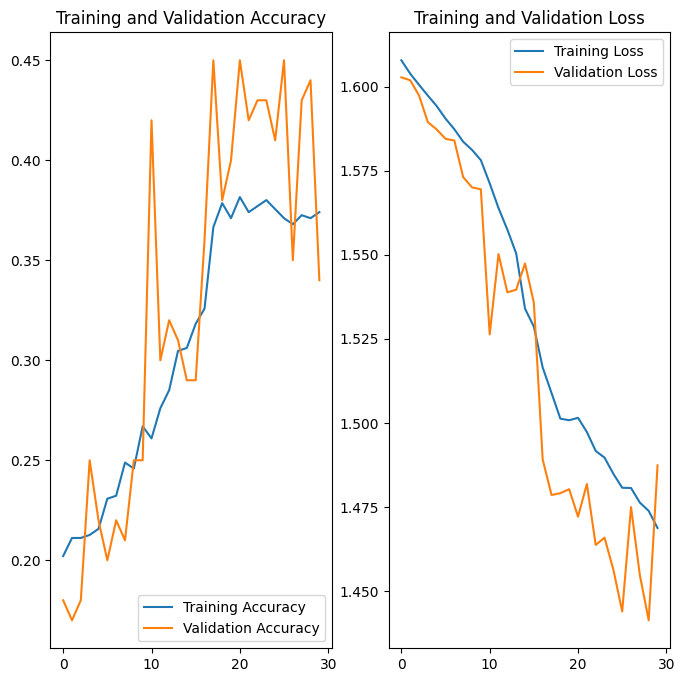

In [ ]:
plot_history(history, num_epochs)

**Model 4**: Augumented data with batch normailzation, Dropout and regularization

In [ ]:
model = Sequential()
model.add(
    Conv3D(
        16,
        (3, 3, 3),
        padding="same",
        input_shape=(10, image_height, image_width, channels),
    )
)
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv3D(32, (2, 2, 2), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv3D(64, (2, 2, 2), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv3D(128, (2, 2, 2), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, kernel_regularizer=l2(0.01), activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))

In [ ]:
model.compile(
    loss="categorical_crossentropy", optimizer="sgd", metrics=["categorical_accuracy"]
)

# summary of model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 10, 50, 50, 16)    1312      
                                                                 
 activation_12 (Activation)  (None, 10, 50, 50, 16)    0         
                                                                 
 max_pooling3d_9 (MaxPoolin  (None, 5, 25, 25, 16)     0         
 g3D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 5, 25, 25, 16)     64        
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 5, 25, 25, 16)     0         
                                                                 
 conv3d_13 (Conv3D)          (None, 5, 25, 25, 32)    

In [ ]:
history = model.fit_generator(
    train_aug_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_aug_generator,
    validation_steps=validation_steps,
    class_weight=None,
    workers=1,
    initial_epoch=0,
)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 6.3791 - categorical_accuracy: 0.3288
Epoch 1: saving model to model_init_2023-12-0517_58_42.919558/model-00001-6.37912-0.32881-6.41037-0.28000.h5
21/21 [==============================] - 76s 4s/step - loss: 6.3791 - categorical_accuracy: 0.3288 - val_loss: 6.4104 - val_categorical_accuracy: 0.2800 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 6.1398 - categorical_accuracy: 0.4118
Epoch 2: saving model to model_init_2023-12-0517_58_42.919558/model-00002-6.13983-0.41176-6.37719-0.22000.h5
21/21 [==============================] - 72s 4s/step - loss: 6.1398 - categorical_accuracy: 0.4118 - val_loss: 6.3772 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 5.9398 - categorical_accuracy: 0.5023
Epoch 3: saving model to model_init_2023-12-0517_58_42.919558/model-00003-5.93980-0.50226-6.36244-0.26000.h5
21/21 [================

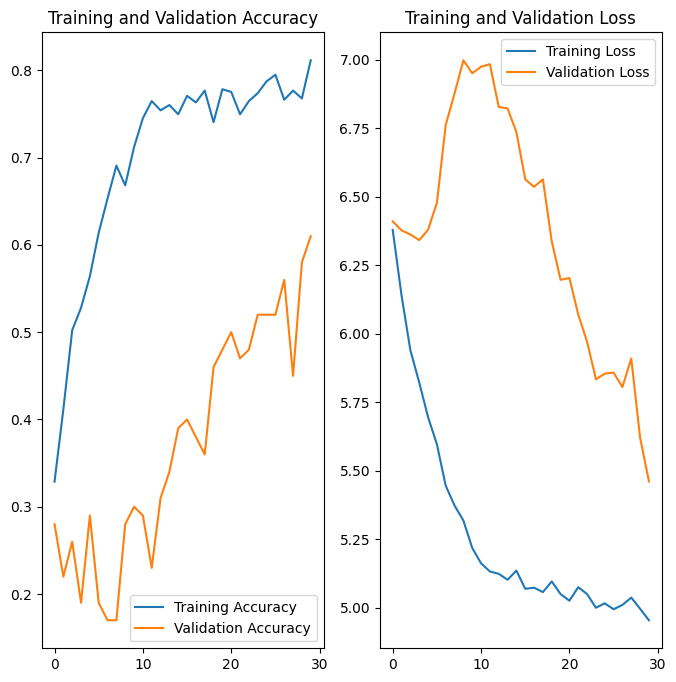

In [ ]:
plot_history(history, num_epochs)

**RNN Model**

In [ ]:
model = Sequential()
model.add(
    TimeDistributed(Conv2D(16, (2, 2), padding="same"), input_shape=(10, 50, 50, 3))
)
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(16, (2, 2))))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(32, (2, 2), padding="same")))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(32, (2, 2), padding="same")))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, return_sequences=False, dropout=0.5))
model.add(Dense(64, kernel_regularizer=l2(0.01)))
model.add(Activation("relu"))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation("softmax"))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
model.compile(
    loss="categorical_crossentropy", optimizer="sgd", metrics=["categorical_accuracy"]
)

# summary of model
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 10, 50, 50, 16)    208       
 ributed)                                                        
                                                                 
 activation_16 (Activation)  (None, 10, 50, 50, 16)    0         
                                                                 
 batch_normalization_8 (Bat  (None, 10, 50, 50, 16)    64        
 chNormalization)                                                
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 49, 49, 16)    1040      
 stributed)                                                      
                                                                 
 activation_17 (Activation)  (None, 10, 49, 49, 16)    0         
                                                      

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=None,
    workers=1,
    initial_epoch=0,
)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.4551 - categorical_accuracy: 0.3695
Epoch 1: saving model to model_init_2023-12-0517_58_42.919558/model-00001-2.45514-0.36953-2.73558-0.16000.h5
21/21 [==============================] - 68s 3s/step - loss: 2.4551 - categorical_accuracy: 0.3695 - val_loss: 2.7356 - val_categorical_accuracy: 0.1600 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 2.3846 - categorical_accuracy: 0.4148
Epoch 2: saving model to model_init_2023-12-0517_58_42.919558/model-00002-2.38461-0.41478-2.73978-0.18000.h5
21/21 [==============================] - 64s 3s/step - loss: 2.3846 - categorical_accuracy: 0.4148 - val_loss: 2.7398 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 2.2579 - categorical_accuracy: 0.4932
Epoch 3: saving model to model_init_2023-12-0517_58_42.919558/model-00003-2.25793-0.49321-2.69987-0.25000.h5
21/21 [================

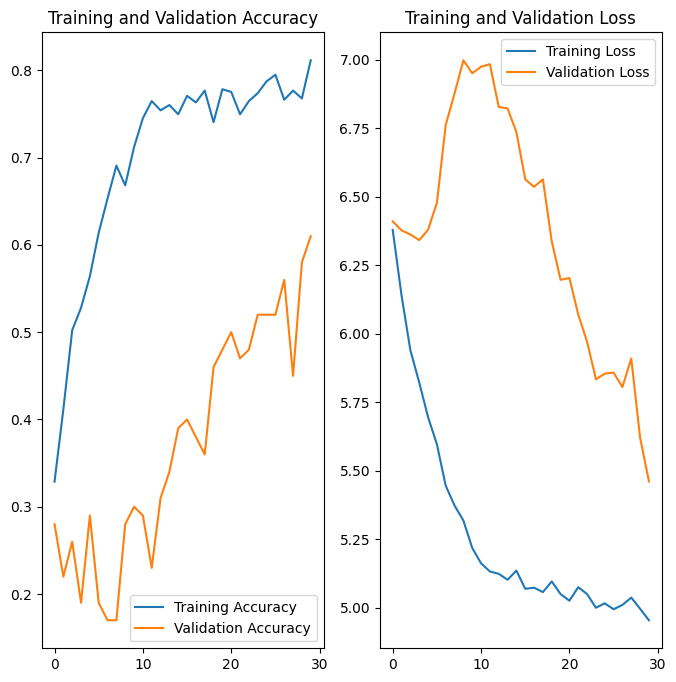

In [ ]:
plot_history(history, num_epochs)

In [ ]:
model2_cnn = Sequential()

model2_cnn.add(
    TimeDistributed(
        Conv2D(16, (3, 3), padding="same", activation="relu"),
        input_shape=(10, 50, 50, 3),
    )
)
model2_cnn.add(TimeDistributed(BatchNormalization()))
model2_cnn.add(TimeDistributed(MaxPooling2D((2, 2))))

model2_cnn.add(TimeDistributed(Conv2D(32, (3, 3), padding="same", activation="relu")))
model2_cnn.add(TimeDistributed(BatchNormalization()))
model2_cnn.add(TimeDistributed(Conv2D(32, (3, 3), padding="same", activation="relu")))
model2_cnn.add(TimeDistributed(MaxPooling2D((2, 2))))

model2_cnn.add(TimeDistributed(Conv2D(64, (3, 3), padding="same", activation="relu")))
model2_cnn.add(TimeDistributed(BatchNormalization()))
model2_cnn.add(TimeDistributed(MaxPooling2D((2, 2))))

model2_cnn.add(TimeDistributed(Conv2D(128, (3, 3), padding="same", activation="relu")))
model2_cnn.add(TimeDistributed(BatchNormalization()))
model2_cnn.add(TimeDistributed(MaxPooling2D((2, 2))))


model2_cnn.add(TimeDistributed(Flatten()))


model2_cnn.add(GRU(64))
model2_cnn.add(Dropout(0.25))

model2_cnn.add(Dense(5, activation="relu"))
model2_cnn.add(Dropout(0.25))

model2_cnn.add(Dense(num_classes, activation="softmax"))

In [ ]:
model2_cnn.compile(
    loss="categorical_crossentropy", optimizer="sgd", metrics=["categorical_accuracy"]
)

# summary of model
model2_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDi  (None, 10, 50, 50, 16)    448       
 stributed)                                                      
                                                                 
 time_distributed_8 (TimeDi  (None, 10, 50, 50, 16)    64        
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, 10, 25, 25, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, 10, 25, 25, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, 10, 25, 25, 32)   

In [ ]:
model2_cnn.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=None,
    workers=1,
    initial_epoch=0,
)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.5741 - categorical_accuracy: 0.2398
Epoch 1: saving model to model_init_2023-12-0517_58_42.919558/model-00001-1.57414-0.23982-1.62515-0.16000.h5
21/21 [==============================] - 65s 3s/step - loss: 1.5741 - categorical_accuracy: 0.2398 - val_loss: 1.6252 - val_categorical_accuracy: 0.1600 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.4789 - categorical_accuracy: 0.2805
Epoch 2: saving model to model_init_2023-12-0517_58_42.919558/model-00002-1.47895-0.28054-1.64478-0.25000.h5
21/21 [==============================] - 66s 3s/step - loss: 1.4789 - categorical_accuracy: 0.2805 - val_loss: 1.6448 - val_categorical_accuracy: 0.2500 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.4228 - categorical_accuracy: 0.3333
Epoch 3: saving model to model_init_2023-12-0517_58_42.919558/model-00003-1.42282-0.33333-1.73407-0.17000.h5
21/21 [================

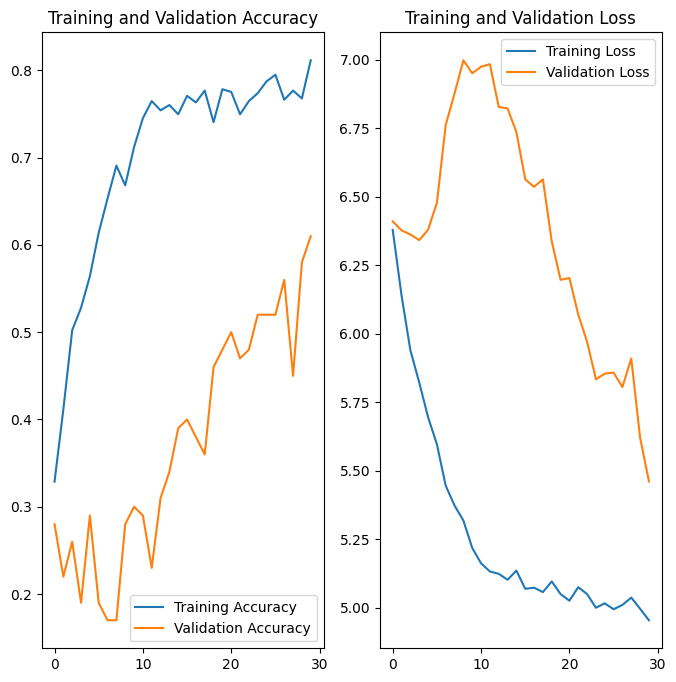

In [ ]:
plot_history(history, num_epochs)